In [10]:
import numpy.random as rd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=":")
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [12]:
rd.seed(71)

T = 500
v_sd = 20 # 観測誤差の標準偏差
i_sd = 10 # interceptの標準偏差
a10 = 10
e_sd1 = .5 # 回帰係数1の変動の標準偏差
a20 = 20
e_sd2 = .8 # 回帰係数1の変動の標準偏差

# 時変回帰係数２つ
e1 = np.random.normal(0, e_sd1, size=T)
a1 = e1.cumsum() + a10
e2 = np.random.normal(0, e_sd2, size=T)
a2 = e2.cumsum() + a20

# intercept
intercept = np.cumsum(np.random.normal(0, i_sd, size=T))

# 説明変数
x1 = rd.normal(10, 10, size=T)
x2 = rd.normal(10, 10, size=T)

# 被説明変数
v = np.random.normal(0, v_sd, size=T) # 観測誤差
y = intercept + a1*x1 + a2*x2 + v
y_noerror = intercept + a1*x1 + a2*x2  # 観測誤差がなかった時の　y


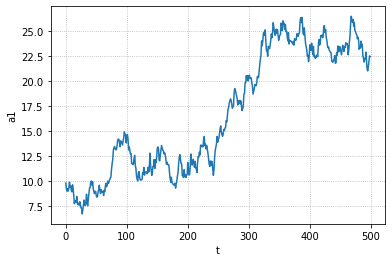

In [13]:
fig, ax = plt.subplots()
t = np.arange(T)
ax.plot(t,a1)
plot_set(ax,"t","a1")

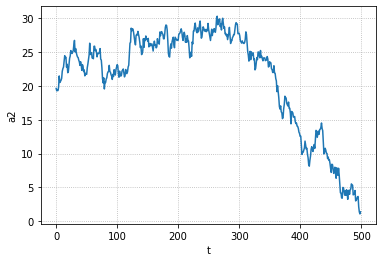

In [15]:
fig, ax = plt.subplots()
ax.plot(t,a2)
plot_set(ax,"t","a2")

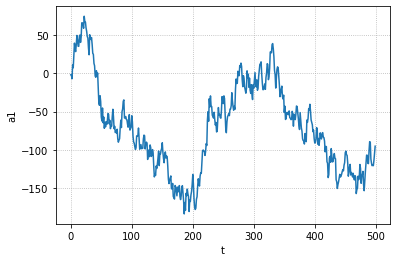

In [16]:
fig, ax = plt.subplots()
ax.plot(t,intercept)
plot_set(ax,"t","intercept")